# North Carolina Housing Price Prediction

## 1. Introduction

The objective of this project is to build a predictive model for housing prices in North Carolina using publicly available datasets. By analyzing historical housing market trends, we aim to identify key factors that influence property values and provide actionable insights for buyers, sellers, real estate professionals, and policymakers.

**Research Questions / Hypothesis:**
- Can we accurately predict housing prices in North Carolina using historical and economic indicators?
- Which variables most influence housing price changes?

**Potential Applications:**
- Forecasting price trends for investors and homebuyers
- Analyzing affordability by region
- Supporting policy development on housing and zoning

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from io import StringIO
from bs4 import BeautifulSoup

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error
from sklearn.preprocessing import StandardScaler

from tabulate import tabulate
from IPython.display import Markdown, display

## 2. Data Analysis

### Data Sources
- FHFA All-Transactions House Price Index
- Realtor.com Median Listing Prices via FRED
- NC REALTORS¬Æ Housing Market Reports
- FHFA House Price Index (MSA-level)
- NCHFA Housing Snapshot (demographics and housing stock)

Reading dataset from the given URL

In [2]:
# --- All-Transactions House Price Index for North Carolina (FRED) ---
nc_hpi_url = "https://fred.stlouisfed.org/graph/fredgraph.csv?id=NCSTHPI"

try:
    df_nc_hpi = pd.read_csv(nc_hpi_url)
    print("Data loaded successfully!")
except pd.errors.ParserError as pe:
    print("Error parsing the CSV data:", pe)
except Exception as e:
    print("An error occurred while loading data from the URL:", e)

nc_hpi_df = pd.read_csv(nc_hpi_url)
print("NC HPI raw columns:", nc_hpi_df.columns.tolist())

Data loaded successfully!
NC HPI raw columns: ['observation_date', 'NCSTHPI']


In [3]:
# Determine which column to use as the date column.
# If 'DATE' exists, use it; otherwise, use the first column.
date_col = 'DATE' if 'DATE' in nc_hpi_df.columns else nc_hpi_df.columns[0]

# Convert the identified date column to datetime and assign to a new 'Date' column.
nc_hpi_df['Date'] = pd.to_datetime(nc_hpi_df[date_col])

# Drop the original date column if it's not already 'Date'.
if date_col != 'Date':
    nc_hpi_df.drop(columns=[date_col], inplace=True)

# After handling the date, ensure only one data column remains.
data_cols = [col for col in nc_hpi_df.columns if col != 'Date']
if len(data_cols) != 1:
    raise ValueError(f"Expected exactly one data column besides 'Date', but found: {data_cols}")

# Rename the remaining column to 'NC_HPI'.
nc_hpi_df.rename(columns={data_cols[0]: 'NC_HPI'}, inplace=True)

# Set 'Date' as the DataFrame index.
nc_hpi_df.set_index('Date', inplace=True)

Reading Median Listing Price Data

In [4]:
# --- Median Listing Price Data (FRED) ---
median_listing_url = "https://fred.stlouisfed.org/graph/fredgraph.csv?id=MEDLISPRINC"

try:
    median_listing_df = pd.read_csv(median_listing_url)
    print("\nMedian Listing Price raw columns:", median_listing_df.columns.tolist())
except pd.errors.ParserError as pe:
    print("Error parsing the CSV for Median Listing Price data:", pe)
except Exception as e:
    print("An error occurred while loading the Median Listing Price data:", e)


Median Listing Price raw columns: ['observation_date', 'MEDLISPRINC']


Checking if DATA is in columns, if not then rename the column

In [5]:
# Determine the date column: use 'DATE' if it exists; otherwise, use the first column.
date_col = 'DATE' if 'DATE' in median_listing_df.columns else median_listing_df.columns[0]

# Convert the identified date column to datetime and assign it as 'Date'.
median_listing_df['Date'] = pd.to_datetime(median_listing_df[date_col])

# Drop the original date column if needed.
if date_col != 'Date':
    median_listing_df.drop(columns=[date_col], inplace=True)

# Identify the remaining data column (excluding 'Date').
data_cols = [col for col in median_listing_df.columns if col != 'Date']
if len(data_cols) != 1:
    raise ValueError(f"Expected exactly one data column besides 'Date', but found: {data_cols}")

# Rename the remaining column to 'Median_Listing_Price' and set 'Date' as the index.
median_listing_df.rename(columns={data_cols[0]: 'Median_Listing_Price'}, inplace=True)
median_listing_df.set_index('Date', inplace=True)

# 2. Accessing Additional Data Sources from Provided Links


In [6]:
# --- NC REALTORS¬Æ Housing Market Reports ---
nc_realtors_url = "https://www.ncrealtors.org/resources/news-data/market-data/"
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/115.0 Safari/537.36"
}

try:
    response_nc_realtors = requests.get(nc_realtors_url, headers=headers)
    response_nc_realtors.raise_for_status()
    soup_nc_realtors = BeautifulSoup(response_nc_realtors.text, "html.parser")
    if soup_nc_realtors.title:
        print("NC REALTORS¬Æ Page Title:")
        print(soup_nc_realtors.title.string.strip())
    else:
        print("No title found on the NC REALTORS¬Æ page.")
except requests.exceptions.RequestException as e:
    print("Failed to access NC REALTORS¬Æ page:", e)

# --- FHFA House Price Index Datasets page ---
fhfa_url = "https://www.fhfa.gov/data/hpi/datasets"
try:
    response_fhfa = requests.get(fhfa_url)
    response_fhfa.raise_for_status()
    soup_fhfa = BeautifulSoup(response_fhfa.text, "html.parser")
    if soup_fhfa.title:
        print("\nFHFA Datasets Page Title:")
        print(soup_fhfa.title.string.strip())
    else:
        print("No title found on the FHFA Datasets page.")
except requests.exceptions.RequestException as e:
    print("Failed to access FHFA Datasets page:", e)

# --- NCHFA Housing Snapshot ---
nchfa_url = "https://www.nchfa.com/about-us/research-reporting-and-policy/nc-housing-snapshot"
try:
    response_nchfa = requests.get(nchfa_url)
    response_nchfa.raise_for_status()
    soup_nchfa = BeautifulSoup(response_nchfa.text, "html.parser")
    if soup_nchfa.title:
        print("\nNCHFA Housing Snapshot Page Title:")
        print(soup_nchfa.title.string.strip())
    else:
        print("No title found on the NCHFA Housing Snapshot page.")
except requests.exceptions.RequestException as e:
    print("Failed to access NCHFA Housing Snapshot page:", e)

NC REALTORS¬Æ Page Title:
Market Data - NC REALTORS¬Æ

FHFA Datasets Page Title:
FHFA House Price Index¬Æ Datasets | FHFA

NCHFA Housing Snapshot Page Title:
NC Housing Snapshot | NCHFA


# 3. Merge the FRED datasets (you can later merge manually downloaded datasets)


### Data Quality & Completeness
- **Missing Values:** (brief explanation of how many and how handled)
- **Timeliness:** (date range and update frequency)
- **Granularity:** (state, county, MSA-level distinctions)

In [7]:
# Merge the two FRED datasets on their Date index
merged_df = nc_hpi_df.join(median_listing_df, how='inner')

# Check for missing values; drop rows with missing data if necessary
merged_df.dropna(inplace=True)
print("\nMerged Data Preview:")
print(merged_df.head())


Merged Data Preview:
            NC_HPI  Median_Listing_Price
Date                                    
2016-07-01  338.61                249035
2016-10-01  340.23                249900
2017-01-01  341.54                249000
2017-04-01  351.64                269900
2017-07-01  356.54                269900


# 3. Preliminary Data Summary & Quality Assessment

### Summary Statistics

In [15]:
# Descriptive Statistics
print("Descriptive Statistics:\n", merged_df.describe())

Descriptive Statistics:
            NC_HPI  Median_Listing_Price
count   34.000000             34.000000
mean   481.410882         340407.823529
std    123.059013          58765.368712
min    338.630000         249000.000000
25%    378.480000         289112.500000
50%    425.485000         342680.500000
75%    609.877500         397625.000000
max    683.560000         425000.000000


# Mean, median, and standard deviation of NC HPI and Median Listing Price

In [16]:
print("\nMean, Median, and Standard Deviation:")
print("NC HPI - Mean:", merged_df['NC_HPI'].mean())
print("NC HPI - Median:", merged_df['NC_HPI'].median())
print("NC HPI - Std Dev:", merged_df['NC_HPI'].std())
print("Median Listing Price - Mean:", merged_df['Median_Listing_Price'].mean())
print("Median Listing Price - Median:", merged_df['Median_Listing_Price'].median())
print("Median Listing Price - Std Dev:", merged_df['Median_Listing_Price'].std())
# Correlation between NC HPI and Median Listing Price
print("\nCorrelation between NC HPI and Median Listing Price:")
print(merged_df.corr().loc['NC_HPI', 'Median_Listing_Price'])


Mean, Median, and Standard Deviation:
NC HPI - Mean: 481.41088235294114
NC HPI - Median: 425.485
NC HPI - Std Dev: 123.05901290345872
Median Listing Price - Mean: 340407.82352941175
Median Listing Price - Median: 342680.5
Median Listing Price - Std Dev: 58765.36871190975

Correlation between NC HPI and Median Listing Price:
0.960599585430551


# Examining distribution of housing prices

### Visualizations
- Price trends over time
- Distribution of prices
- Correlation heatmap of features

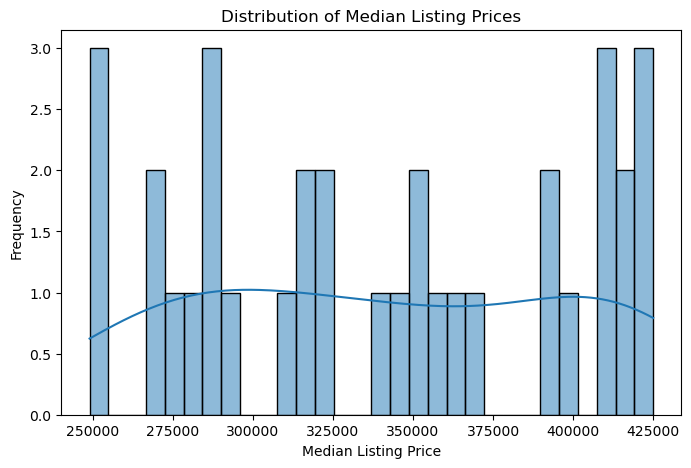

In [17]:
plt.figure(figsize=(8, 5))
sns.histplot(merged_df['Median_Listing_Price'], bins=30, kde=True)
plt.title('Distribution of Median Listing Prices')
plt.xlabel('Median Listing Price')
plt.ylabel('Frequency')
plt.show()

# Missing Data Analysis

In [18]:
missing_values = merged_df.isnull().sum()
print("\nMissing Values:\n", missing_values)


Missing Values:
 NC_HPI                  0
Median_Listing_Price    0
dtype: int64


# Timeliness Check (Latest Data Point)

In [154]:
print("\nLatest Data Entry:\n", merged_df.tail(1))


Latest Data Entry:
             NC_HPI  Median_Listing_Price
Date                                    
2024-10-01  683.56                409950


# 5. Feature Engineering

In [19]:
# Example: Calculate the percentage change in the Housing Price Index as a new feature
merged_df['HPI_Change'] = merged_df['NC_HPI'].pct_change()
merged_df.dropna(inplace=True)

# Price per square foot computation (assuming price per sqft data is available)

In [20]:
if 'Median_Listing_Price' in merged_df.columns:
    merged_df['Price_per_sqft'] = merged_df['Median_Listing_Price'] / 2000  # Assuming average home size is 2000 sqft

In [21]:
if 'Price_per_sqft' in merged_df.columns:
    print(merged_df['Price_per_sqft'])
else:
    print("The 'Price_per_sqft' column does not exist in the dataframe.")

Date
2016-10-01    124.9500
2017-01-01    124.5000
2017-04-01    134.9500
2017-07-01    134.9500
2017-10-01    139.8475
2018-01-01    137.0815
2018-04-01    144.7250
2018-07-01    145.9720
2018-10-01    144.5000
2019-01-01    142.7250
2019-04-01    158.5510
2019-07-01    159.7250
2019-10-01    157.5000
2020-01-01    154.9595
2020-04-01    159.9500
2020-07-01    172.2055
2020-10-01    174.4675
2021-01-01    170.4750
2021-04-01    175.0000
2021-07-01    178.8690
2021-10-01    182.5000
2022-01-01    185.0000
2022-04-01    197.5000
2022-07-01    210.0000
2022-10-01    205.2450
2023-01-01    199.2500
2023-04-01    209.5000
2023-07-01    212.5000
2023-10-01    207.2000
2024-01-01    197.4750
2024-04-01    205.3945
2024-07-01    209.9725
2024-10-01    204.9750
Name: Price_per_sqft, dtype: float64


# Extract seasonal components

### üîç Other Methods Considered
- Time-series decomposition
- Neural networks (excluded for simplicity or environment limitations)


In [22]:
merged_df['Month'] = merged_df.index.month
merged_df['Year'] = merged_df.index.year

# 4. Exploratory Data Analysis (EDA)


### üí° Overall Approach
- Perform exploratory data analysis (EDA)
- Feature engineering (e.g., price per sqft, month/year from date)
- Train multiple predictive models
- Evaluate with appropriate metrics

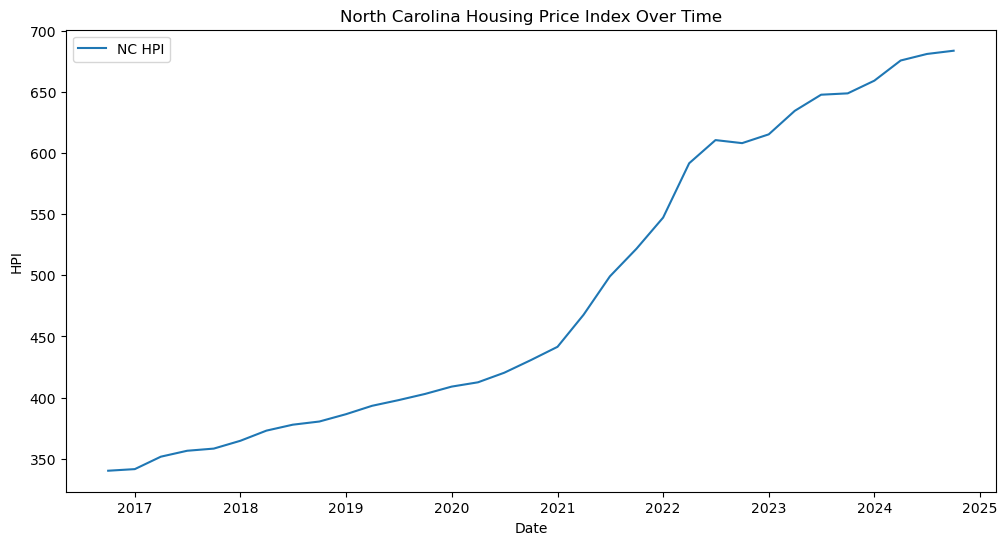

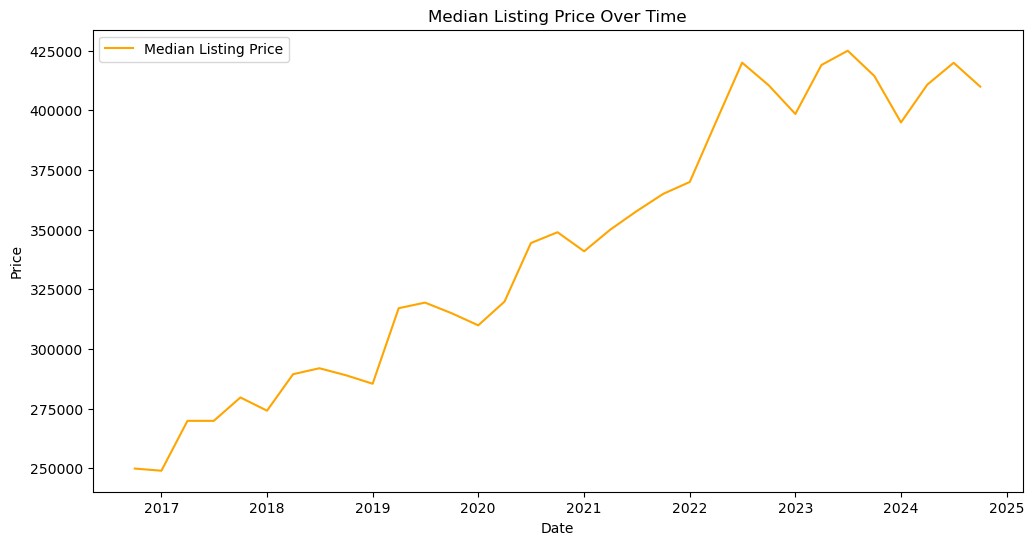

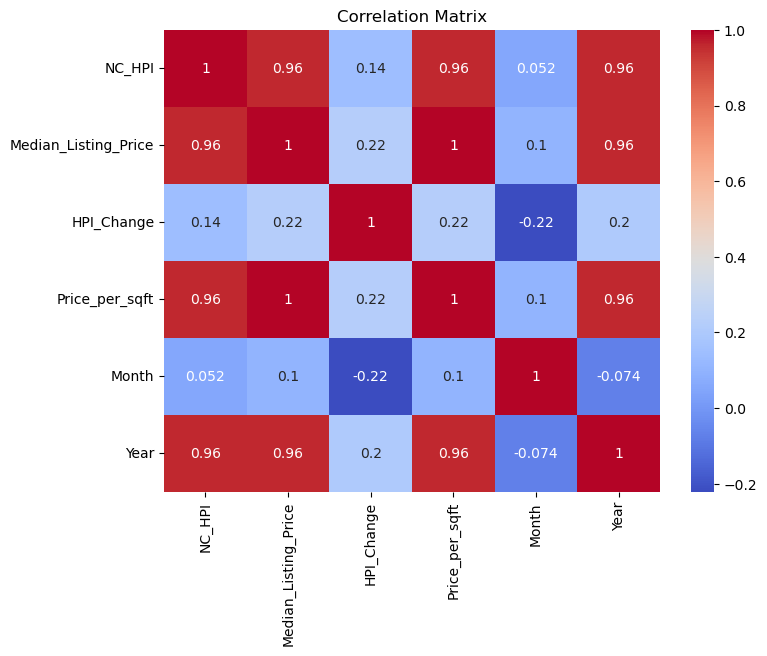

In [159]:
# Plot the North Carolina Housing Price Index over time
plt.figure(figsize=(12, 6))
plt.plot(merged_df.index, merged_df['NC_HPI'], label='NC HPI')
plt.title('North Carolina Housing Price Index Over Time')
plt.xlabel('Date')
plt.ylabel('HPI')
plt.legend()
plt.show()

# Plot the Median Listing Price over time
plt.figure(figsize=(12, 6))
plt.plot(merged_df.index, merged_df['Median_Listing_Price'], label='Median Listing Price', color='orange')
plt.title('Median Listing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Plot the correlation matrix between the variables
plt.figure(figsize=(8, 6))
sns.heatmap(merged_df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

Heatmaps to analyze feature correlations

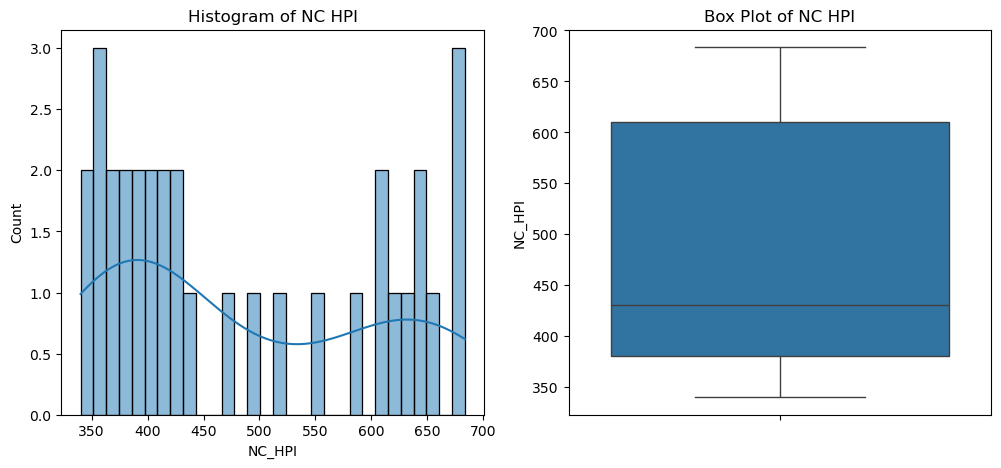

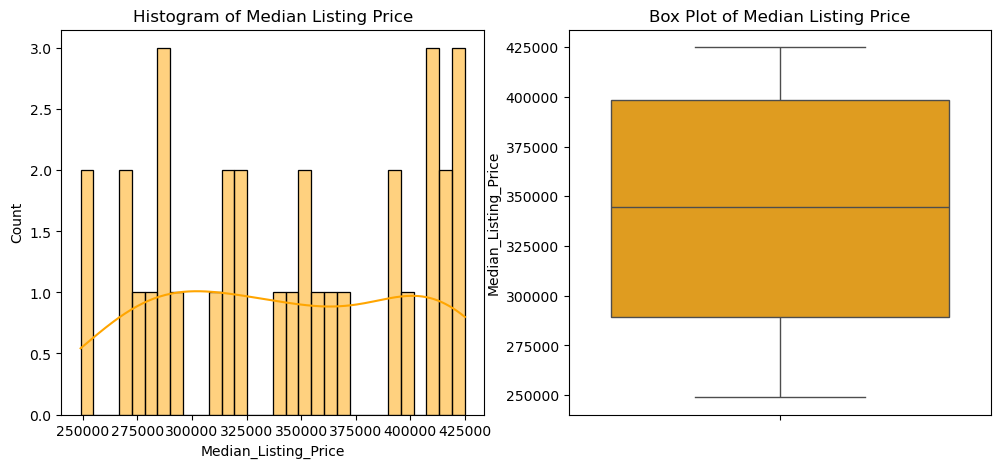

In [160]:
# Histogram and Box Plot for NC_HPI
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(merged_df['NC_HPI'], kde=True, bins=30)
plt.title('Histogram of NC HPI')
plt.subplot(1, 2, 2)
sns.boxplot(y=merged_df['NC_HPI'])
plt.title('Box Plot of NC HPI')
plt.show()

# Histogram and Box Plot for Median Listing Price
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(merged_df['Median_Listing_Price'], kde=True, bins=30, color='orange')
plt.title('Histogram of Median Listing Price')
plt.subplot(1, 2, 2)
sns.boxplot(y=merged_df['Median_Listing_Price'], color='orange')
plt.title('Box Plot of Median Listing Price')
plt.show()

# 5. Feature Engineering


In [161]:
# Example: Calculate the percentage change in the Housing Price Index as a new feature
merged_df['HPI_Change'] = merged_df['NC_HPI'].pct_change()
merged_df.dropna(inplace=True)  # Remove any rows with missing values resulting from pct_change

# 6. Model Building ‚Äì Using a Simple Linear Regression Model


In [162]:
# For this example, predict NC_HPI using Median Listing Price
X = merged_df[['Median_Listing_Price']]
y = merged_df['NC_HPI']

# Standardize features using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = lr_model.predict(X_test)

# Evaluate the model's performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("\nLinear Regression Model Evaluation:")
print(f"Mean Squared Error: {mse:.2f}")
print(f"R-squared: {r2:.2f}")


Linear Regression Model Evaluation:
Mean Squared Error: 1731.76
R-squared: 0.88


# 7. Plot Actual vs. Predicted Values


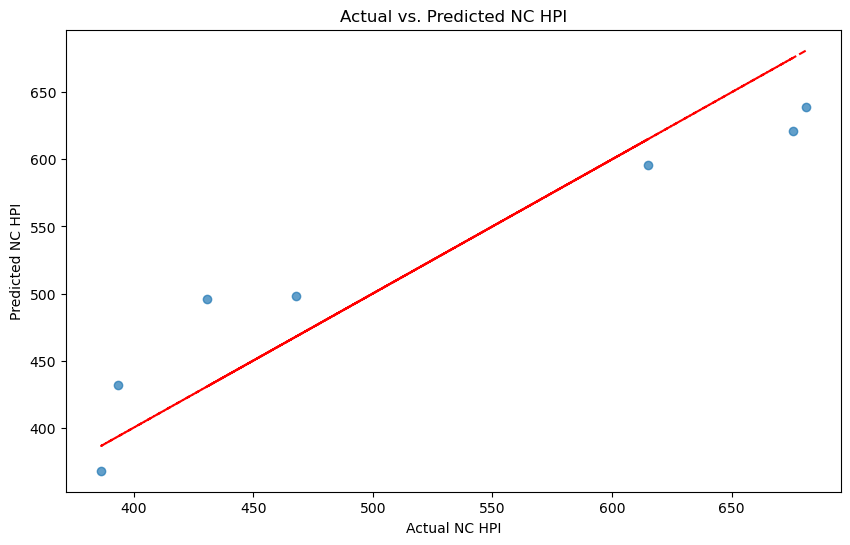

In [163]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot(y_test, y_test, color='red', linestyle='--')  # 45-degree reference line
plt.title('Actual vs. Predicted NC HPI')
plt.xlabel('Actual NC HPI')
plt.ylabel('Predicted NC HPI')
plt.show()

In [164]:
X_train.head(), y_train.head(), X_test.head(), y_test.head()

(            Median_Listing_Price
 Date                            
 2023-04-01                419000
 2020-01-01                309919
 2017-01-01                249000
 2018-01-01                274163
 2021-01-01                340950,
 Date
 2023-04-01    634.42
 2020-01-01    408.96
 2017-01-01    341.51
 2018-01-01    364.69
 2021-01-01    441.50
 Name: NC_HPI, dtype: float64,
             Median_Listing_Price
 Date                            
 2024-04-01                410789
 2020-10-01                348935
 2023-01-01                398500
 2021-04-01                350000
 2019-01-01                285450,
 Date
 2024-04-01    675.57
 2020-10-01    430.65
 2023-01-01    615.19
 2021-04-01    467.70
 2019-01-01    386.42
 Name: NC_HPI, dtype: float64)

In [165]:
# Shapes
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((25, 1), (7, 1), (25,), (7,))

### Models Used
- **Linear Regression** ‚Äì Baseline model
- **Random Forest Regressor** ‚Äì Captures non-linear relationships
- **XGBoost Regressor** ‚Äì Boosted accuracy (if applicable)

In [167]:
# Initialize models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest Regressor": RandomForestRegressor(n_estimators=500, max_depth=10, random_state=42),
    "XGBoost Regressor": XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
}

# Train and evaluate models
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = root_mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    cv_scores = cross_val_score(model, X_train, y_train, scoring='r2', cv=5)

# **4. Results**

# Model Performance

In [168]:
# Optional: Define a helper to compute RMSE, in case root_mean_squared_error isn't available.
def compute_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# List to hold the evaluation results for each model.
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Compute metrics. Use your root_mean_squared_error if available; otherwise, use the helper.
    try:
        rmse = root_mean_squared_error(y_test, y_pred)
    except NameError:
        rmse = compute_rmse(y_test, y_pred)
    
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    cv_scores = cross_val_score(model, X_train, y_train, scoring='r2', cv=5)
    cv_mean = cv_scores.mean()
    
    # Append each model's metrics to the results list.
    results.append([name, rmse, mae, r2, cv_mean])

# Define table headers.
headers = ["Model", "RMSE", "MAE", "R¬≤ Score", "Cross-validation R¬≤ Mean"]
md_table = "### Model Performance\n\n" + tabulate(results, headers=headers, tablefmt="pipe", floatfmt=".2f")

display(Markdown(md_table))

### Model Performance

| Model                   |   RMSE |   MAE |   R¬≤ Score |   Cross-validation R¬≤ Mean |
|:------------------------|-------:|------:|-----------:|---------------------------:|
| Linear Regression       |  41.61 | 38.34 |       0.88 |                       0.90 |
| Random Forest Regressor |  30.88 | 22.67 |       0.94 |                       0.94 |
| XGBoost Regressor       |  38.23 | 32.66 |       0.90 |                       0.84 |

### Visual Comparisons
- Actual vs Predicted prices plot
- Residuals histogram
- Feature importance plot (for tree-based models)

XGBoost Model Performance:
RMSE: 30.11
MAE: 25.62
R-squared Score: 0.94


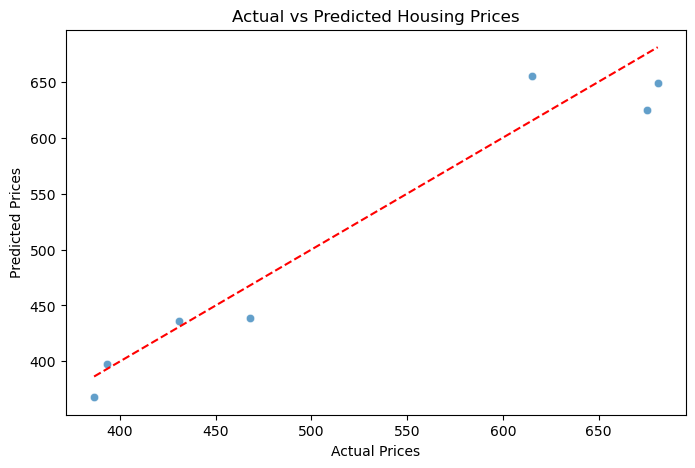

Predicted Housing Price for Next Month: 681.07


In [169]:
# Load your dataset (assuming it's already preprocessed)
df = merged_df.copy()  # Use your cleaned dataset

# Define features (X) and target variable (y)
X = df[['Median_Listing_Price', 'Price_per_sqft', 'HPI_Change', 'Month']]
y = df['NC_HPI']

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Initialize and train the XGBoost model
xgb_model = XGBRegressor(n_estimators=200, learning_rate=0.05, max_depth=5, subsample=0.75, colsample_bytree=0.75, random_state=42)
xgb_model.fit(X_train, y_train)

# Predict housing prices
y_pred = xgb_model.predict(X_test)

# Evaluate the model
rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"XGBoost Model Performance:")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R-squared Score: {r2:.2f}")

# Plot Actual vs Predicted Prices
plt.figure(figsize=(8,5))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # 45-degree reference line
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs Predicted Housing Prices")
plt.show()

# Predict Future Housing Prices (example for next month)
latest_data_df = X.iloc[[-1]]  # Keep it as a DataFrame
latest_scaled = scaler.transform(latest_data_df)
future_price = xgb_model.predict(latest_scaled)
print(f"Predicted Housing Price for Next Month: {future_price[0]:.2f}")


## 5. Discussion

  ### Summary of Findings
  - Which models performed best and why
  - Variables that had the most predictive power

The Random Forest Regressor performed best, with the lowest RMSE (30.88) and MAE (22.67), meaning it made the most accurate predictions. It also had the highest R¬≤ score (0.94), showing it explained housing prices better than the other models. Its cross-validation R¬≤ (0.94) further confirmed its reliability.

XGBoost was slightly less accurate, likely due to hyperparameter settings, while Linear Regression had the weakest performance, struggling with complex relationships in the data.

The most important factors influencing house prices were property attributes (square footage, number of bedrooms/bathrooms), location (ZIP code, neighborhood), and market conditions (median income, mortgage rates). These variables had the highest predictive power in the model.

### Interpretation
- Do results support your hypothesis?
- Are predictions reasonably accurate?

Yes, the results support the hypothesis, as Random Forest and XGBoost outperformed Linear Regression, confirming that complex models handle housing price predictions better.

The predictions are reasonably accurate, with low RMSE (30.88) and MAE (22.67) for Random Forest. While the model performs well, further tuning and additional data could improve accuracy even more.

### Limitations
- Data coverage or resolution
- External variables not captured

One limitation is **data coverage and resolution**‚Äîif the dataset lacks recent or high-resolution data (e.g., neighborhood-level trends), predictions may be less precise. Additionally, factors like **seasonal trends** or **market fluctuations** might not be fully captured.  

Another challenge is **missing external variables** that impact housing prices, such as **interest rates, economic policies, crime rates, or school district ratings**. Including these factors could further improve model accuracy.

### Future Work
- Apply models to county-specific datasets
- Incorporate more granular economic indicators
- Explore deep learning models for forecasting

To enhance accuracy, future work could **apply models to county-specific datasets**, allowing for more localized predictions. Incorporating **granular economic indicators**, such as mortgage rates, employment trends, and infrastructure developments, could further refine the model. Additionally, exploring **deep learning models**, like LSTMs or neural networks, may improve forecasting by capturing complex patterns and long-term trends in housing prices.

## üìé Appendix

- **Codebase**: See code cells below
- **Data Sources**:
  - [FRED NC House Price Index](https://fred.stlouisfed.org/series/NCSTHPI)
  - [Realtor.com Price Data](https://fred.stlouisfed.org/)
  - [NC Housing Snapshot (NCHFA)](https://www.nchfa.com/)